In [4]:
import numpy as np
from numpy import linalg as la

import theano

from theano import tensor as T
import theano.tensor.slinalg

import scipy
from scipy import linalg
np.set_printoptions(suppress=True, linewidth=250)

from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
def hadamard(left, right, shape, r):
    u1, s1, v1 = left
    u2, s2, v2 = right
    r = s1.shape[0] if r is None else r
    
    indices = T.argsort(T.slinalg.kron(T.diag(s1).reshape((1, -1)), T.diag(s2).reshape((1, -1))).ravel())
    svds = []
    for rg in range(r):
        u = T.zeros((shape[0], r))
        s = T.zeros((r,))
        v = T.zeros((r, shape[1]))
        indices_r = indices[r * rg: r * (rg + 1)]
        ind1, ind2 = indices_r // s1.shape[0], indices_r % s1.shape[0]
        s = T.diag(T.diag(s1)[ind1] * T.diag(s2)[ind2])
        for i in np.arange(shape[0]):
            u = T.set_subtensor(u[i, :], u1[i, :][ind1] * u2[i, :][ind2])
        for i in np.arange(shape[1]):
            v = T.set_subtensor(v[:, i], v1[:, i][ind1] * v2[:, i][ind2])
        # rq decomposition of v
        Qv, Rv = T.nlinalg.qr(v[::-1].T)
        Rv = Rv.T[::-1]
        Rv = Rv[:, ::-1]
        Qv = Qv.T[::-1]
        
        u = u.dot(s).dot(Rv)
        u, s, v = T.nlinalg.svd(u, full_matrices=False)
        v = v.dot(Qv)
        svds.append((u, s, v))
    init_usv = svds[0]
    for next_usv in svds[1:]:
        u, s, v = init_usv
        u1, s1, v1 = next_usv        
        v = T.stack((v, v1), 0).reshape((-1, v.shape[1]))
        
        # rq decomposition of v
        Qv, Rv = T.nlinalg.qr(v[::-1].T)
        Rv = Rv.T[::-1]
        Rv = Rv[:, ::-1]
        Qv = Qv.T[::-1]
        
        u = T.stack((u, u1), 1).reshape((u.shape[0], -1)).dot(T.diag(T.concatenate((s, s1)))).dot(Rv)
        u, s, v = T.nlinalg.svd(u, full_matrices=False)
        u, s, v, Qv = u[:, :r], s[:r], v[:r, :], Qv[:, :]
        v = v.dot(Qv)[:r, :]
        init_usv = (u, s, v)
    u, s, v = init_usv
    s = T.diag(s)
    return u, s, v

In [143]:
def hadamard_np(left, right, shape, r):
    u1, s1, v1 = left
    u2, s2, v2 = right
    r = s1.shape[0] if r is None else r
    
    indices = np.argsort(np.kron(np.diag(s1).reshape((1, -1)), np.diag(s2).reshape((1, -1))).ravel())
    svds = []
    r = r*2
    for rg in range(2):
        u = np.zeros((shape[0], r))
        s = np.zeros((r,))
        v = np.zeros((r, shape[1]))
        indices_r = indices[r * rg: r * (rg + 1)]
        ind1, ind2 = indices_r // s1.shape[0], indices_r % s1.shape[0]
        print((np.diag(s1)[ind1] * np.diag(s2)[ind2]).shape)
        s = np.diag(np.diag(s1)[ind1] * np.diag(s2)[ind2])
        for i in np.arange(shape[0]):
            u[i, :] = u1[i, :][ind1] * u2[i, :][ind2]
        for i in np.arange(shape[1]):
            v[:, i] = v1[:, i][ind1] * v2[:, i][ind2]
        # rq decomposition of v
        Qv, Rv = la.qr(v[::-1].T)
        Rv = Rv.T[::-1]
        Rv = Rv[:, ::-1]
        Qv = Qv.T[::-1]
        
        u = u.dot(s).dot(Rv)
        u, s, v = la.svd(u, full_matrices=False)
        v = v.dot(Qv)
        svds.append((u, s, v))
    init_usv = svds[0]
    for next_usv in svds[1:]:
        u, s, v = init_usv
        u1, s1, v1 = next_usv        
        v = np.vstack((v, v1))
        
        # rq decomposition of v
        Qv, Rv = la.qr(v[::-1].T)
        Rv = Rv.T[::-1]
        Rv = Rv[:, ::-1]
        Qv = Qv.T[::-1]
        
        u = np.hstack((u, u1)).dot(np.diag(np.concatenate((s, s1)))).dot(Rv)
        u, s, v = la.svd(u, full_matrices=False)
        u, s, v, Qv = u[:, :r], s[:r], v[:r, :], Qv[:, :]
        v = v.dot(Qv)
        init_usv = (u, s, v)
    u, s, v = init_usv
    s = np.diag(s)
    return u, s, v


def hadamard_np(left, right, shape, r):
    u1, s1, v1 = left
    u2, s2, v2 = right
    r = s1.shape[0] if r is None else r
    
    u = np.zeros((shape[0], r*r))
    s = np.zeros((r*r,))
    v = np.zeros((r*r, shape[1]))
    u[:, :] = np.repeat(u1, r, 1) * np.tile(u2, (1, r))
    s = np.kron(s1, s2)
    v[:, :] = np.repeat(v1, r, 0) * np.tile(v2, (r, 1))
    Qv, Rv = la.qr(v[::-1].T)
    Rv = Rv.T[::-1]
    Rv = Rv[:, ::-1]
    Qv = Qv.T[::-1]
    
    u = u.dot(s).dot(Rv)
    u, s, v = la.svd(u, full_matrices=False)
    v = v.dot(Qv)
    return u[:, :], np.diag(s[:]), v[:]

In [321]:
shape = (400, 64)
x1, x2 = np.random.normal(size=shape), np.random.normal(size=shape)


nnext = []
for t in range(10, 410, 10):
    shape = (400, t)
    x1, x2 = np.random.normal(size=shape), np.random.normal(size=shape)
    rr = []
    for r in range(1, 25):
        def csvd(x, r=None):
            r = min(x.shape) if r is None else r
            u, s, v = la.svd(x, full_matrices=False)
            return u[:, :r], np.diag(s[:r]), v[:r]

        U1, S1, V1 = csvd(x1, r)
        U2, S2, V2 = csvd(x2, r)
        U, S, V = hadamard_np((U1, S1, V1), (U1, S1, V1), shape, r)
        idx = np.argmax(np.isclose(np.diag(S), 0))
        if r > 1 and idx == 0:
            nnext.append((r, t))
            break
        rr.append((np.average(np.isclose(np.diag(S), 0)), np.sum(~np.isclose(np.diag(S), 0))))

In [ ]:
len(nnext)

In [323]:
nnext

[(4, 10),
 (6, 20),
 (8, 30),
 (9, 40),
 (10, 50),
 (11, 60),
 (12, 70),
 (13, 80),
 (13, 90),
 (14, 100),
 (15, 110),
 (15, 120),
 (16, 130),
 (17, 140),
 (17, 150),
 (18, 160),
 (18, 170),
 (19, 180),
 (19, 190),
 (20, 200),
 (20, 210),
 (21, 220),
 (21, 230),
 (22, 240),
 (22, 250),
 (23, 260),
 (23, 270),
 (24, 280),
 (24, 290),
 (24, 300)]

In [335]:
ranks, tets = list(zip(*nnext))

In [ ]:
ranks, tets = np.array(ranks), np.array(tets)

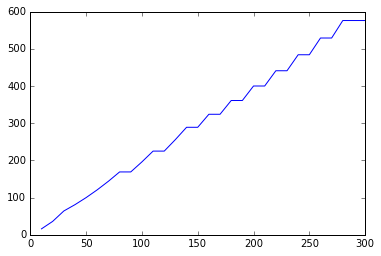

In [342]:
plt.plot(tets, ranks**2)

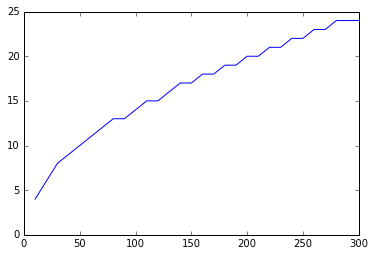

In [332]:
plt.plot(*list(zip(*nnext))[::-1])

In [300]:
percents, ranks = zip(*rr)

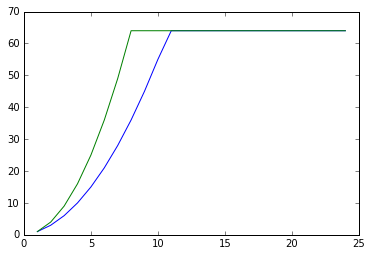

In [301]:
plt.plot(np.arange(1, len(rr) + 1), ranks)
plt.plot(np.arange(1, len(rr) + 1), np.clip(np.arange(1, len(rr) + 1)**2, a_min=0, a_max=min(shape)))

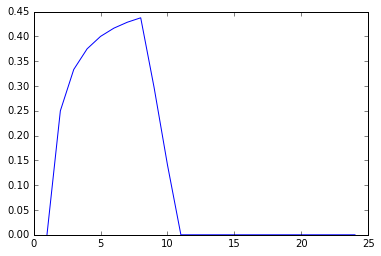

In [302]:
plt.plot(np.arange(1, len(rr) + 1), percents)

In [303]:
percents

(0.0,
 0.25,
 0.33333333333333331,
 0.375,
 0.40000000000000002,
 0.41666666666666669,
 0.42857142857142855,
 0.4375,
 0.296875,
 0.140625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

In [304]:
m1 = (U1 @ S1 @ V1) * (U1 @ S1 @ V1)
m2 = U @ S @ V

In [204]:
m1 - m2

array([[ 0., -0., -0., ..., -0., -0., -0.],
       [ 0., -0., -0., ...,  0.,  0.,  0.],
       [-0.,  0., -0., ..., -0.,  0., -0.],
       ..., 
       [ 0., -0.,  0., ...,  0.,  0., -0.],
       [-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0., -0., ...,  0.,  0.,  0.]])

In [205]:
la.norm(m1 - m2) / (la.norm(m1))

3.0736090219424316e-15

array([ 57.9098209 ,  19.86503604,  18.41474516,  17.46516787,  16.83715884,  16.30350211,  15.9436219 ,  15.08237045,  14.5996072 ,  14.25330103,  13.44288551,  13.05663751,  12.97772244,  12.16928412,  12.04492513,  11.90485463,  11.55243137,
        11.28420776,  11.11114244,  10.44075384,   9.98648667,   9.80912393,   9.63406614,   9.38560873,   9.03992915,   8.97240675,   8.85753499,   8.56061326,   8.25354643,   7.97946533,   7.82343523,   7.67198812,   7.33093211,   7.23070531,
         6.9701494 ,   6.72844536,   6.49956446,   6.25353304,   6.22790498,   6.13480627,   5.92031079,   5.76891495,   5.69403561,   5.45710882,   5.44254158,   5.1595679 ,   4.95631484,   4.65741857,   4.56920585,   4.36397027,   4.20111533,
         4.10017022,   3.88481709,   3.73040608,   3.58061673,   3.48710151,   3.41861861,   3.31613343,   3.14023045,   2.99153416,   2.79994652,   2.71877347,   2.5869304 ,   2.49764974,   2.38869573,   2.18698387,   2.13721207,   2.03009414,
         1.87936385,

In [200]:
Up, Sp, Vp = hadamard_np((U1, S1, V1), (U1, S1, V1), shape, r)

array([[-6.36843763,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.29598666,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.67971558,  0.        ],
       [ 0.        ,  0.        ,  0.        , -2.86854654]])

In [18]:
scipy.linalg.kron(np.array([1, 2, 3]).reshape((-1, 1)[::-1]), np.array([4, 5, 6]).reshape((-1, 1)[::-1])).ravel()

array([ 4,  5,  6,  8, 10, 12, 12, 15, 18])

In [24]:
s1 = T.diag(theano.shared(np.random.random(10)))
s2 = T.diag(theano.shared(np.random.random(10)))
r = 5

In [27]:
indices = T.argsort(T.slinalg.kron(T.diag(s1).reshape((1, -1)), T.diag(s2).reshape((1, -1))).ravel())[::-1][:r]

In [28]:
ind1, ind2 = indices // s1.shape[0], indices % s1.shape[0]

In [32]:
max_elems = T.diag(s1)[ind1] * T.diag(s2)[ind2]

max_elems2 = (T.slinalg.kron(T.diag(s1).reshape((1, -1)), T.diag(s2).reshape((1, -1))).ravel())[indices]

In [272]:
u1, s1, v1, u2, s2, v2 = [T.matrix(name) for name in ['u1', 's1', 'v1', 'u2', 's2', 'v2']]

shape = (200, 200)
r = 5

In [35]:
f = theano.function([u1, s1, v1, u2, s2, v2], hadamard((u1, s1, v1), (u2, s2, v2), shape, r))

In [274]:
x1, x2 = np.random.normal(size=shape), np.random.normal(size=shape)

In [38]:
U, S, V = f(U1, S1, V1, U1, S1, V1)

In [56]:
m1 = (U1 @ S1 @ V1) * (U1 @ S1 @ V1)
m2 = U @ S @ V

In [57]:
m1 - m2

array([[ 0.,  0.,  0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [58]:
la.norm(m1 - m2) / (la.norm(m1))

4.9424554320502884e-15

In [162]:
U.T @ U

array([[ 0.03699734, -0.00280174, -0.00280174,  0.00240964,  0.00240964,  0.0104432 , -0.00241367, -0.00241367,  0.00888653,  0.00487989,  0.00487989, -0.0014662 , -0.0014662 ,  0.000507  ,  0.000507  ,  0.00917638],
       [-0.00280174,  0.0104432 ,  0.0104432 , -0.00241367, -0.00241367,  0.00104933,  0.00140529,  0.00140529, -0.00146161, -0.0014662 , -0.0014662 ,  0.00112486,  0.00112486, -0.00012811, -0.00012811,  0.00100172],
       [-0.00280174,  0.0104432 ,  0.0104432 , -0.00241367, -0.00241367,  0.00104933,  0.00140529,  0.00140529, -0.00146161, -0.0014662 , -0.0014662 ,  0.00112486,  0.00112486, -0.00012811, -0.00012811,  0.00100172],
       [ 0.00240964, -0.00241367, -0.00241367,  0.00888653,  0.00888653,  0.00140529, -0.00146161, -0.00146161,  0.00133693,  0.000507  ,  0.000507  , -0.00012811, -0.00012811,  0.00127015,  0.00127015, -0.00022579],
       [ 0.00240964, -0.00241367, -0.00241367,  0.00888653,  0.00888653,  0.00140529, -0.00146161, -0.00146161,  0.00133693,  0.0005

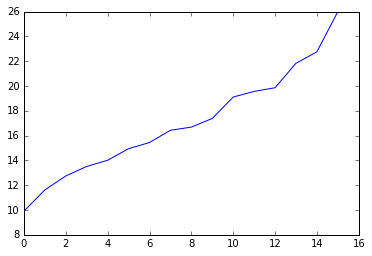

In [91]:
plt.plot(np.sort(np.kron(np.diag(S1), np.diag(S2))))

In [72]:
pp = 10*np.arange(4)[:, None] + np.arange(5)
tt = 10*np.arange(4)[:, None] + np.arange(5)

TypeError: tile() takes 2 positional arguments but 3 were given

In [104]:
np.repeat(pp, tt.shape[1], 1) * np.tile(tt, (1, pp.shape[1]))

array([[   0,    0,    0,    0,    0,    0,    1,    2,    3,    4,    0,    2,    4,    6,    8,    0,    3,    6,    9,   12,    0,    4,    8,   12,   16],
       [ 100,  110,  120,  130,  140,  110,  121,  132,  143,  154,  120,  132,  144,  156,  168,  130,  143,  156,  169,  182,  140,  154,  168,  182,  196],
       [ 400,  420,  440,  460,  480,  420,  441,  462,  483,  504,  440,  462,  484,  506,  528,  460,  483,  506,  529,  552,  480,  504,  528,  552,  576],
       [ 900,  930,  960,  990, 1020,  930,  961,  992, 1023, 1054,  960,  992, 1024, 1056, 1088,  990, 1023, 1056, 1089, 1122, 1020, 1054, 1088, 1122, 1156]])

In [100]:
uu = np.zeros((tt.shape[0], tt.shape[1] * pp.shape[1]))
for i in np.arange(tt.shape[0]):
    uu[i, :] = np.kron(pp[i, :], tt[i, :])

In [105]:
uu - np.repeat(pp, tt.shape[1], 1) * np.tile(tt, (1, pp.shape[1]))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [102]:
np.repeat(pp, tt.shape[0], 1)

array([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4],
       [10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14],
       [20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24],
       [30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34]])

In [103]:
np.tile(tt, (1, pp.shape[1]))

array([[ 0,  1,  2,  3,  4,  0,  1,  2,  3,  4,  0,  1,  2,  3,  4,  0,  1,  2,  3,  4,  0,  1,  2,  3,  4],
       [10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14],
       [20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24, 20, 21, 22, 23, 24],
       [30, 31, 32, 33, 34, 30, 31, 32, 33, 34, 30, 31, 32, 33, 34, 30, 31, 32, 33, 34, 30, 31, 32, 33, 34]])